In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("2025 Allianz Datathon Dataset.xlsx", sheet_name="Climate Data")

In [3]:
df_2014 = df[df["Year"] >= 2014].copy()
df_2014.head()

Bureau of Meteorology station number  Year  Month  Day  \
1461                                 71075  2014      1    1   
1462                                 71075  2014      1    2   
1463                                 71075  2014      1    3   
1464                                 71075  2014      1    4   
1465                                 71075  2014      1    5   

      Maximum temperature (Degree C)  Minimum temperature (Degree C)  \
1461                            14.3                             2.5   
1462                            18.1                             8.8   
1463                            14.8                             9.5   
1464                            11.6                             4.2   
1465                            14.5                             5.0   

      Rainfall amount (millimetres)  
1461                            0.0  
1462                            0.8  
1463                            0.0  
1464                            0.2  
1465                            0.0

In [4]:
station_to_resort = {
    71032: "Thredbo AWS",
    71075: "Perisher AWS",
    72161: "Cabramurra SMHEA AWS",
    83024: "Mount Buller",
    83084: "Falls Creek",
    83085: "Mount Hotham",
    85291: "Mount Baw Baw"
}
# Add new column
df_2014["Resort"] = df_2014["Bureau of Meteorology station number"].map(station_to_resort)
df_2014.head()

Bureau of Meteorology station number  Year  Month  Day  \
1461                                 71075  2014      1    1   
1462                                 71075  2014      1    2   
1463                                 71075  2014      1    3   
1464                                 71075  2014      1    4   
1465                                 71075  2014      1    5   

      Maximum temperature (Degree C)  Minimum temperature (Degree C)  \
1461                            14.3                             2.5   
1462                            18.1                             8.8   
1463                            14.8                             9.5   
1464                            11.6                             4.2   
1465                            14.5                             5.0   

      Rainfall amount (millimetres)        Resort  
1461                            0.0  Perisher AWS  
1462                            0.8  Perisher AWS  
1463                            0.0  Perisher AWS  
1464                            0.2  Perisher AWS  
1465                            0.0  Perisher AWS

In [5]:
# Build datetime column
df_2014["Date"] = pd.to_datetime(df_2014[["Year", "Month", "Day"]])

# Preprocess

In [6]:
df_weekly = (
    df_2014.groupby(["Resort", pd.Grouper(key="Date", freq="W-SUN")])
    .agg({
        "Maximum temperature (Degree C)": "mean",
        "Minimum temperature (Degree C)": "mean",
        "Rainfall amount (millimetres)": "sum"
    })
    .reset_index()
    .rename(columns={
        "Maximum temperature (Degree C)": "TempMax",
        "Minimum temperature (Degree C)": "TempMin",
        "Rainfall amount (millimetres)": "Rainfall"
    })
)

In [35]:
# Create lag features per resort
for resort in df_weekly["Resort"].unique():
    mask = df_weekly["Resort"] == resort
    for col in ["TempMax", "TempMin", "Rainfall"]:
        df_weekly.loc[mask, f"{col}_lag1"] = df_weekly.loc[mask, col].shift(1)
        df_weekly.loc[mask, f"{col}_lag2"] = df_weekly.loc[mask, col].shift(2)

# Drop rows with missing lags
df_weekly = df_weekly.dropna()

df_weekly["weekofyear"] = df_weekly["Date"].dt.isocalendar().week
df_weekly["sin_week"] = np.sin(2 * np.pi * df_weekly["weekofyear"] / 52)
df_weekly["cos_week"] = np.cos(2 * np.pi * df_weekly["weekofyear"] / 52)

# Modelling Temp MAX Min 

In [36]:
train = df_weekly[df_weekly["Date"] < "2023-01-01"]
test  = df_weekly[df_weekly["Date"] >= "2023-01-01"]

features = ["TempMax_lag1","TempMax_lag2",
            "TempMin_lag1","TempMin_lag2",
            "Rainfall_lag1","Rainfall_lag2","sin_week","cos_week"]

targets = ["TempMax","TempMin","Rainfall"]

X_train, y_train = train[features], train[targets]
X_test, y_test   = test[features], test[targets]

In [50]:
# Define base estimator
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
# Wrap in MultiOutput
multi_rf = MultiOutputRegressor(rf)

# Define param grid (applies to the base RandomForest inside MultiOutput)
param_grid = {
    "estimator__n_estimators": [200, 300, 500],
    "estimator__max_depth": [10, 20, None],
    "estimator__max_features": ["sqrt", "log2"],
    "estimator__min_samples_split": [2, 5],
    "estimator__min_samples_leaf": [1, 2, 4]
}

# Grid search with R² as scoring (averaged across targets)
grid = GridSearchCV(
    multi_rf,
    param_grid,
    cv=3,
    scoring="r2",   # you can also try 'neg_mean_squared_error'
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best params: {'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 500}
Best CV score: 0.5939294372048515


In [54]:
# Strip 'estimator__' prefix
best_params = {k.replace("estimator__", ""): v for k, v in grid.best_params_.items()}

# Retrain final MultiOutputRegressor with cleaned params
best_rf = MultiOutputRegressor(
    RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
)
best_rf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(max_features='sqrt',
                                                     n_estimators=500,
                                                     n_jobs=-1,
                                                     random_state=42))

## Evaluation

In [56]:
# Predict
y_pred = best_rf.predict(X_test)

# Copy test set and add predictions
pred_df = test.copy().reset_index(drop=True)
for i, col in enumerate(targets):
    pred_df[f"{col}_pred"] = y_pred[:, i]

# Define SMAPE
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# Evaluate per variable
print("\n=== Forecast Performance (per variable) ===")
for col in targets:
    actual = y_test[col].values
    pred   = pred_df[f"{col}_pred"].values

    rmse = mean_squared_error(actual, pred, squared=False)
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    smape_score = smape(actual, pred)
    spearman_corr = spearmanr(actual, pred).correlation

    print(f"{col}: RMSE={rmse:.3f}, MAE={mae:.3f}, "
          f"SMAPE={smape_score:.2f}%, R²={r2:.3f}, Spearman={spearman_corr:.3f}")



=== Forecast Performance (per variable) ===
TempMax: RMSE=2.625, MAE=2.128, SMAPE=34.44%, R²=0.836, Spearman=0.909
TempMin: RMSE=2.378, MAE=1.924, SMAPE=68.96%, R²=0.754, Spearman=0.869
Rainfall: RMSE=33.387, MAE=25.085, SMAPE=96.54%, R²=-0.035, Spearman=0.206


the result model form maximum and minimum temperature is still acceptabale where model can explain 73-80% of variance, relative error is moderate and forecast error is within 2-3 degrees celcius on average. On the otherhand, this model can't predict rainfall that well.

## Test and Actual Comparison

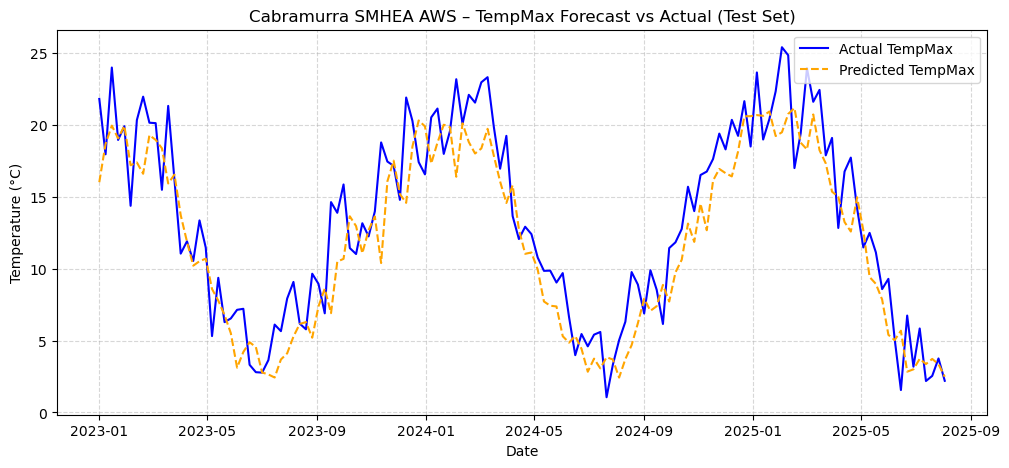

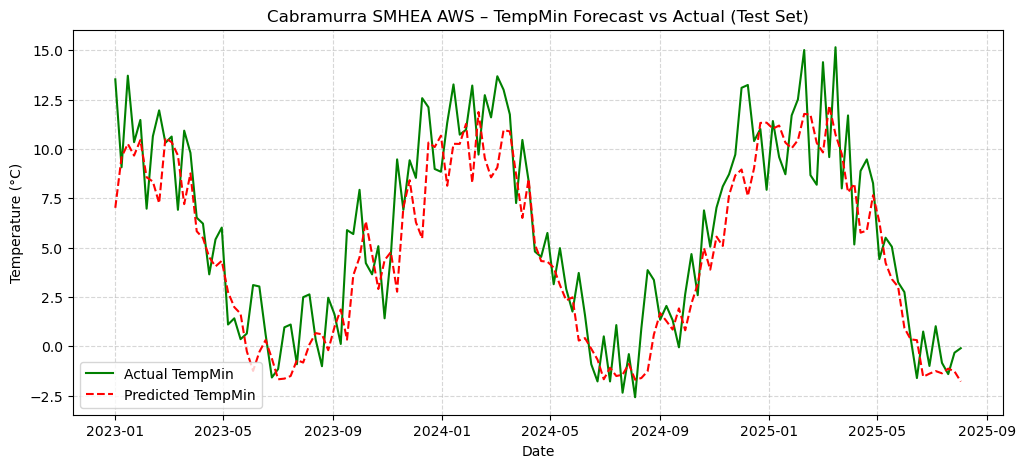

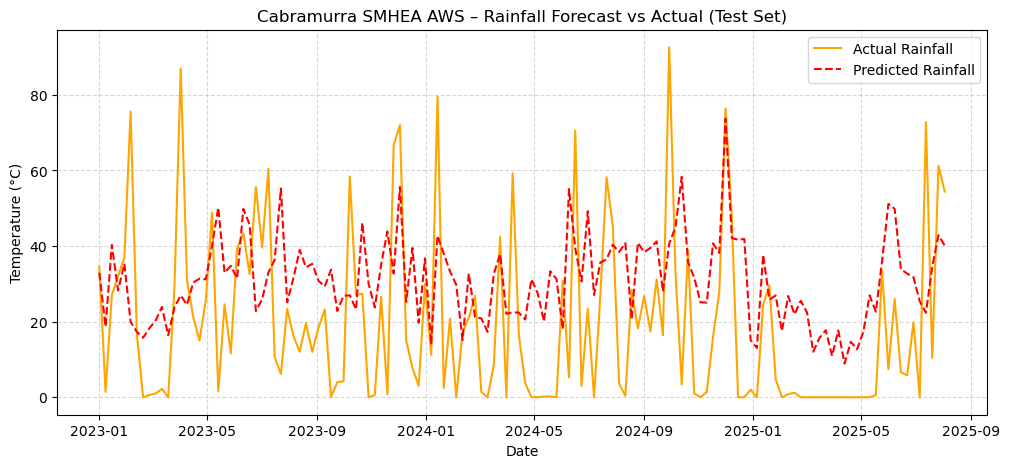

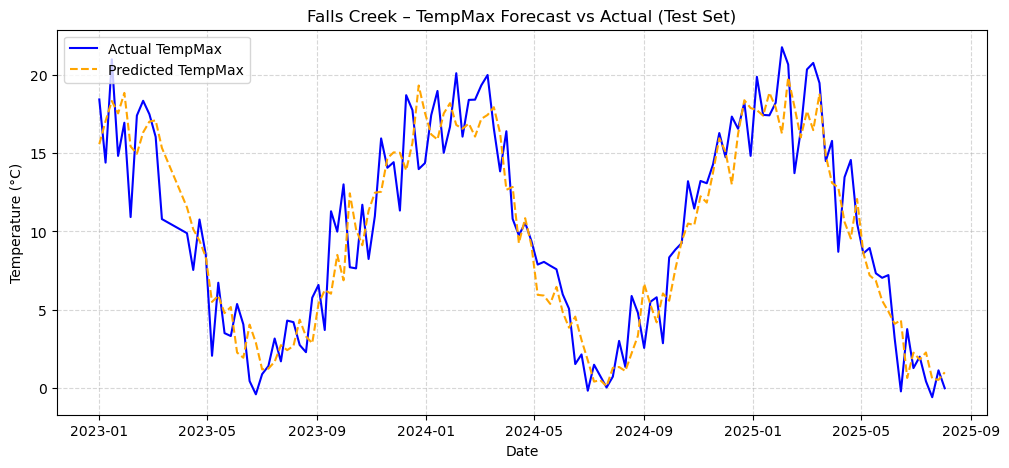

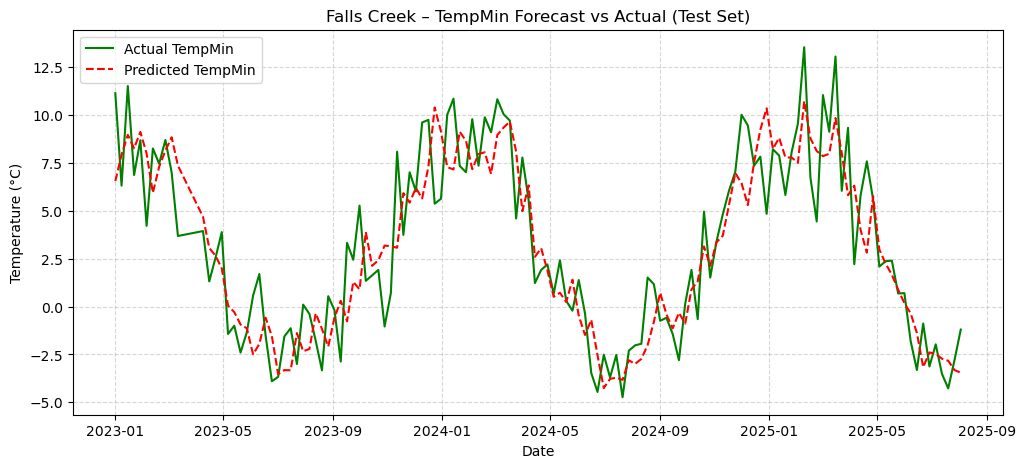

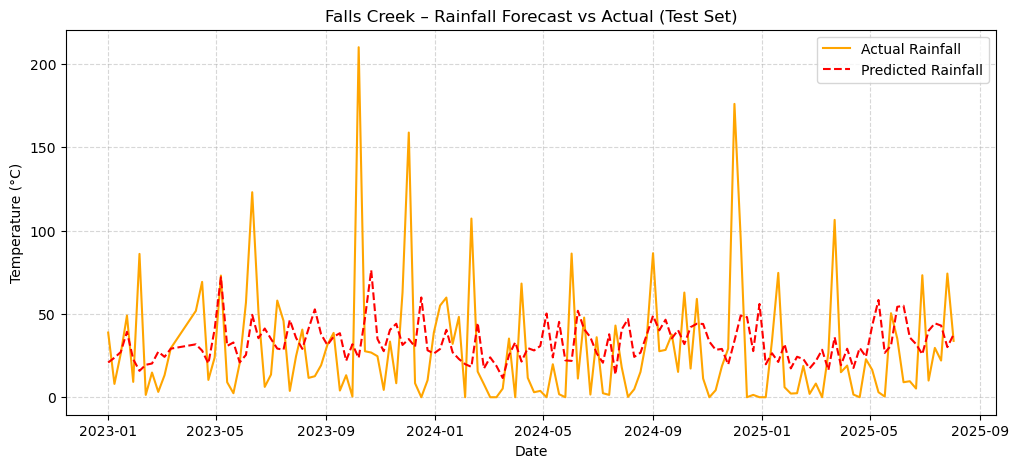

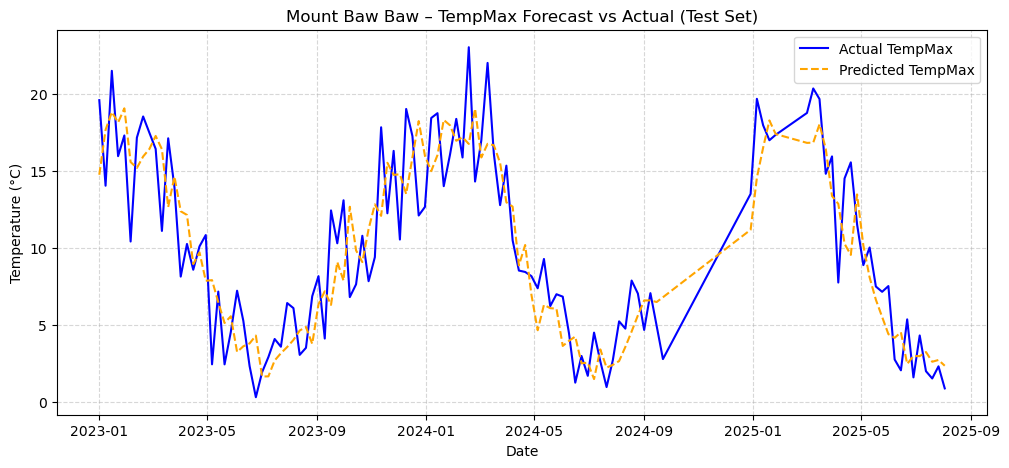

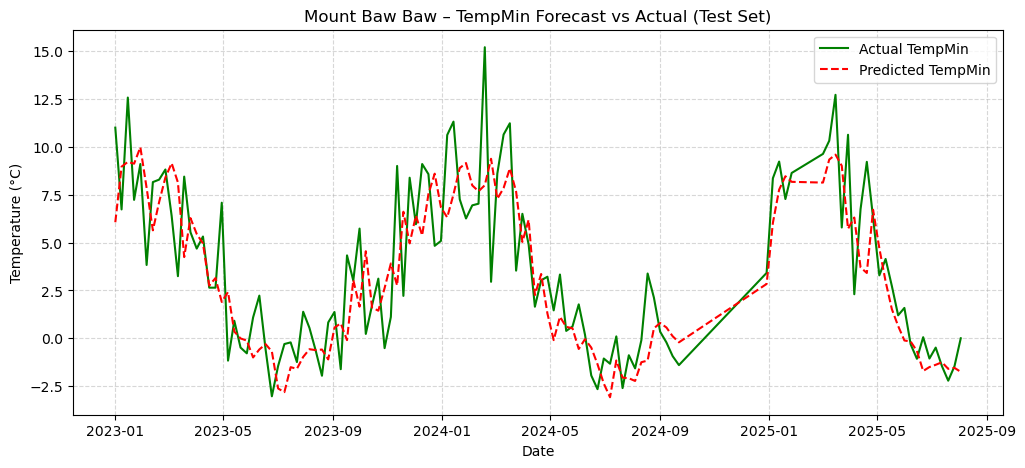

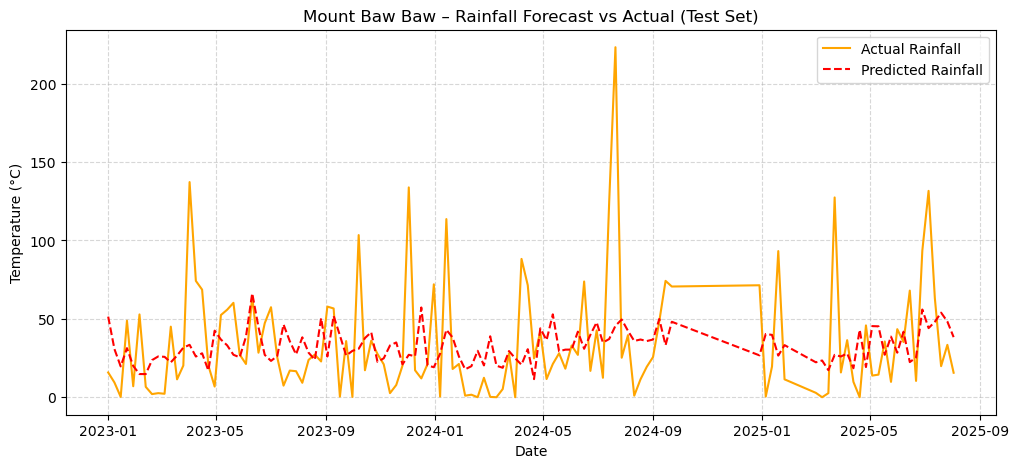

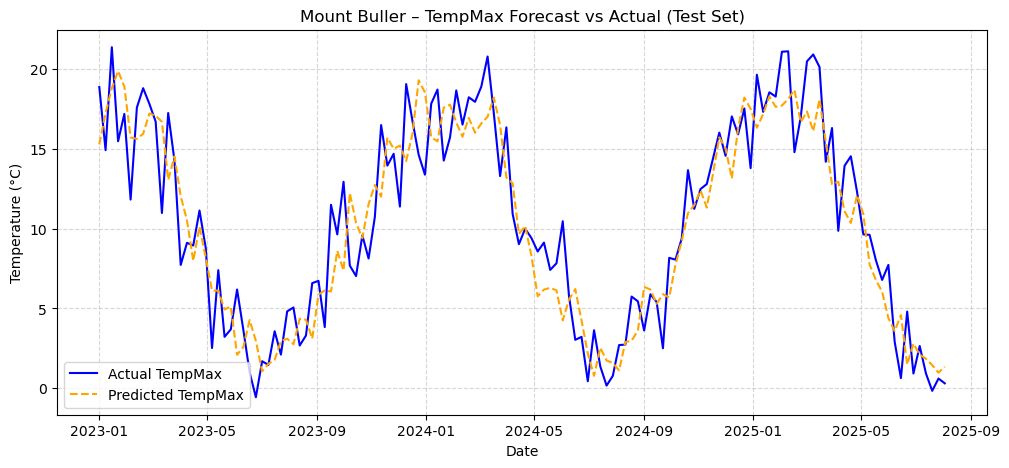

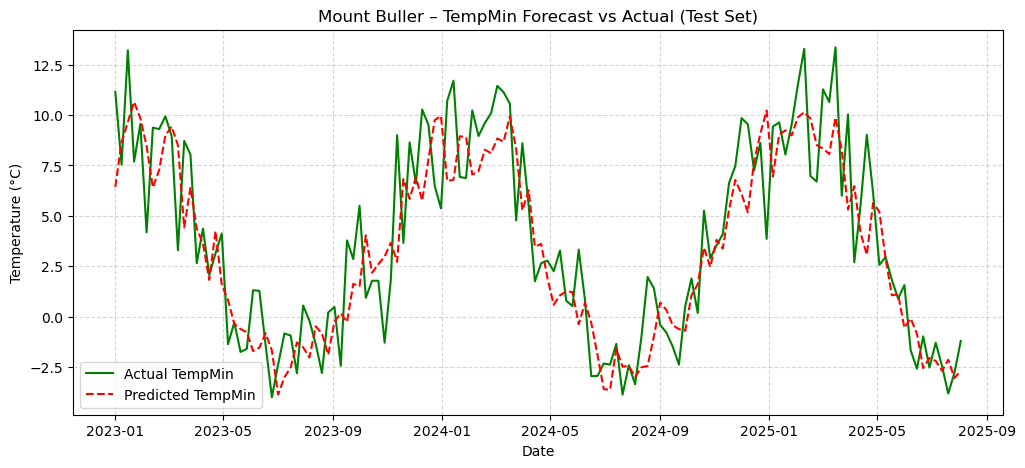

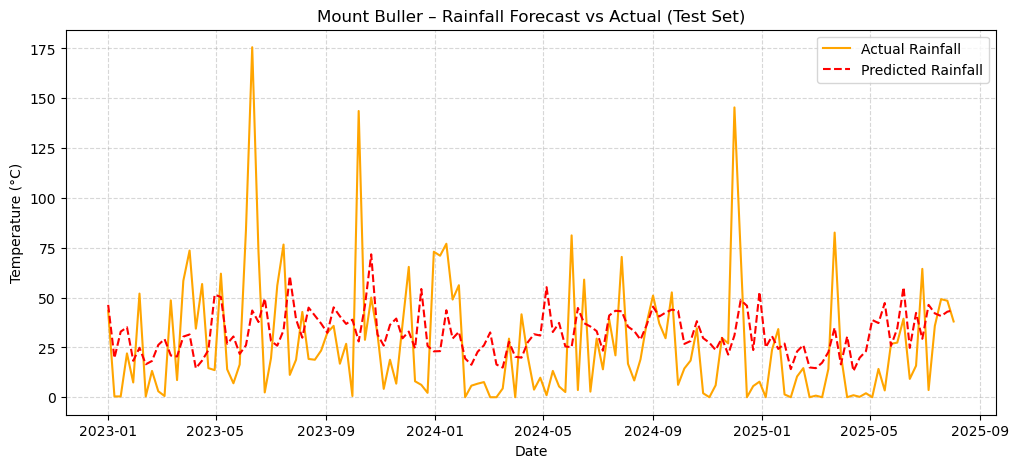

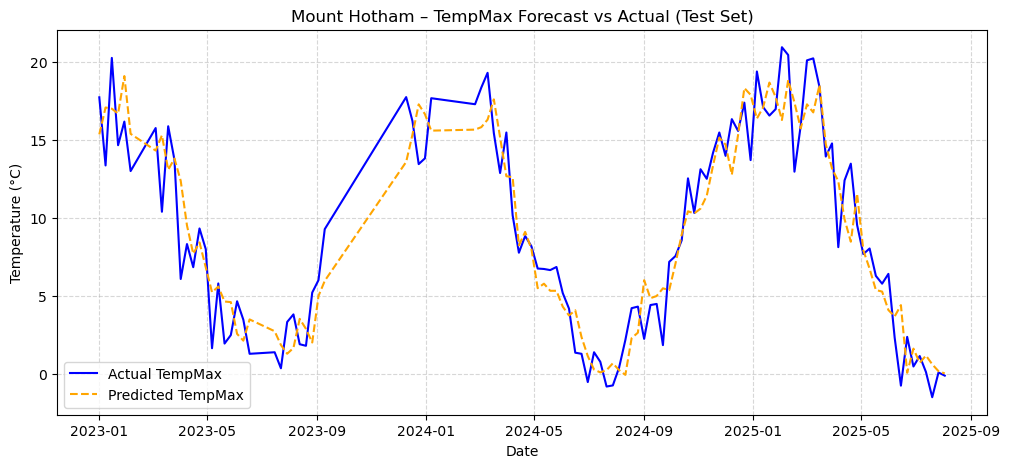

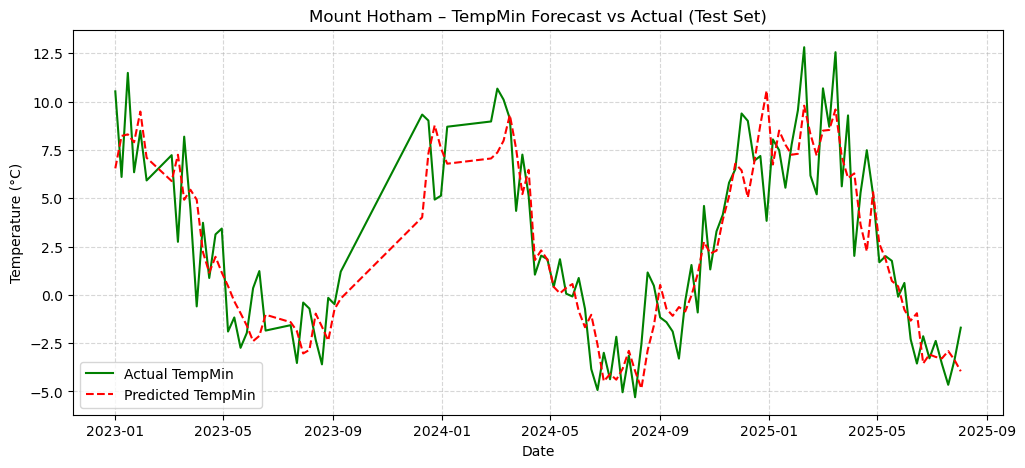

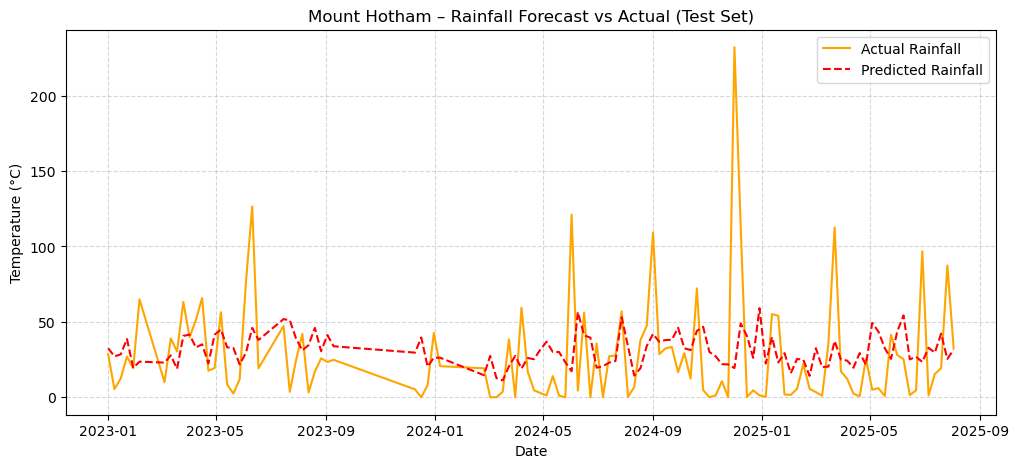

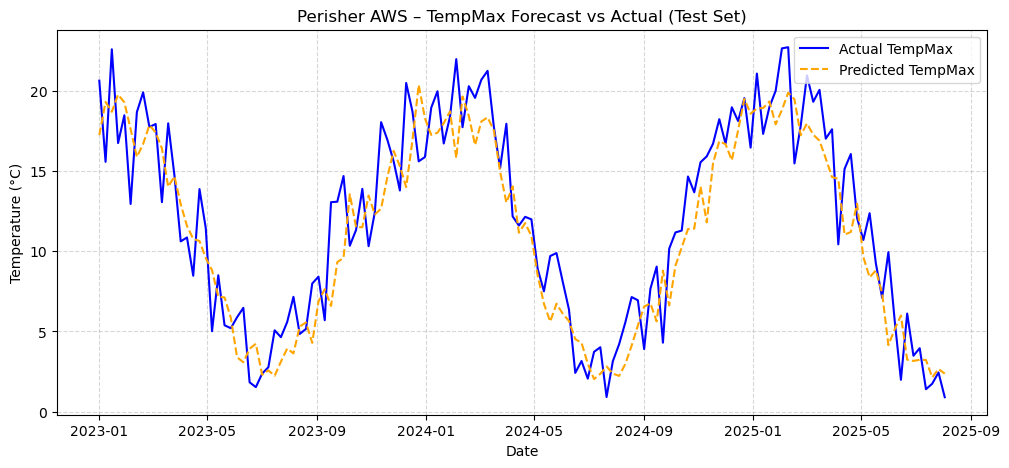

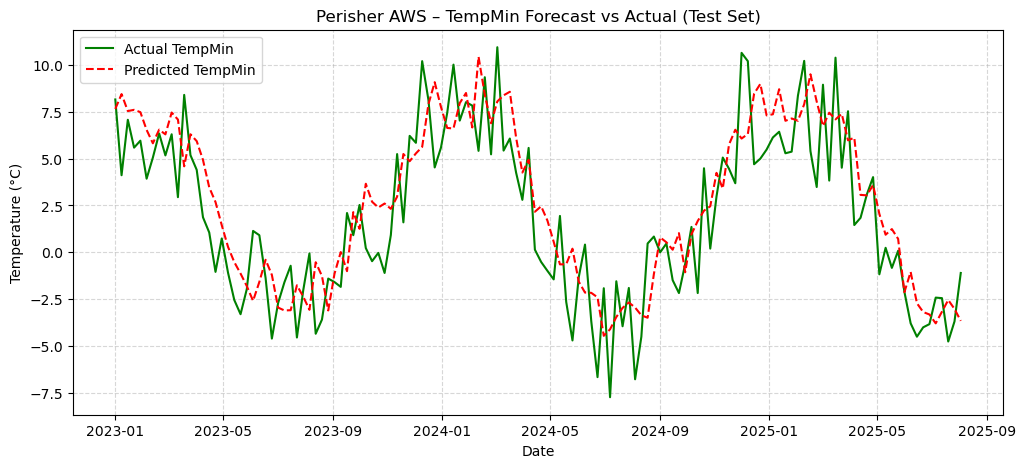

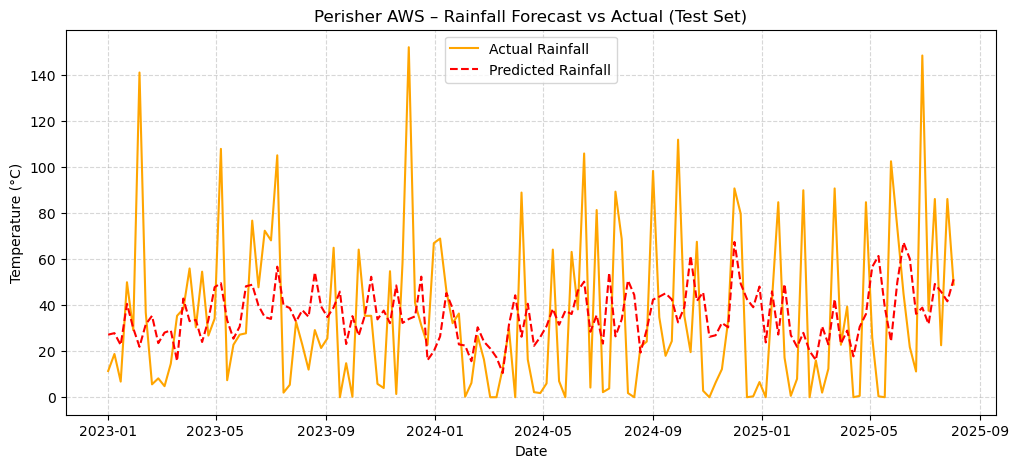

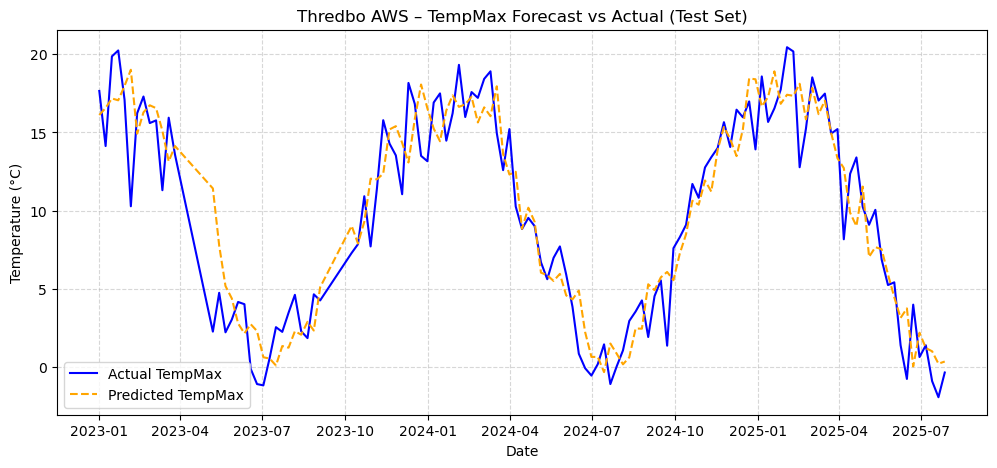

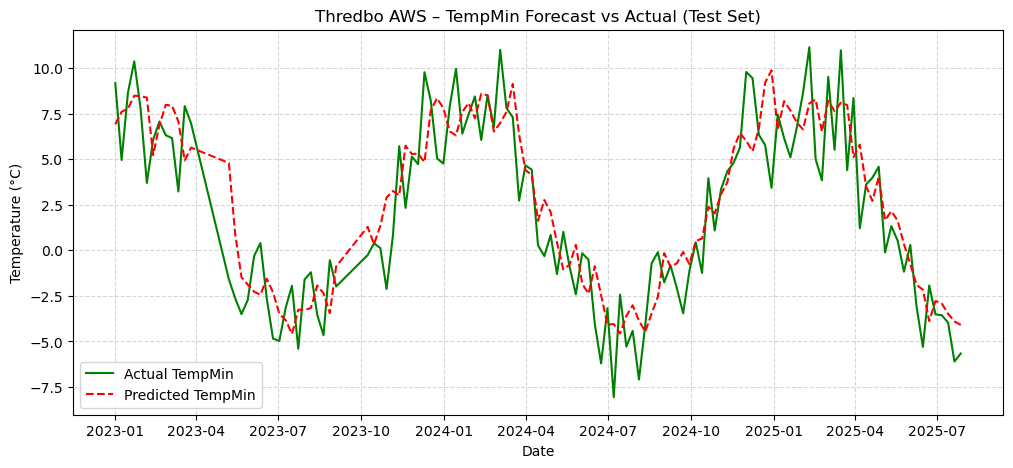

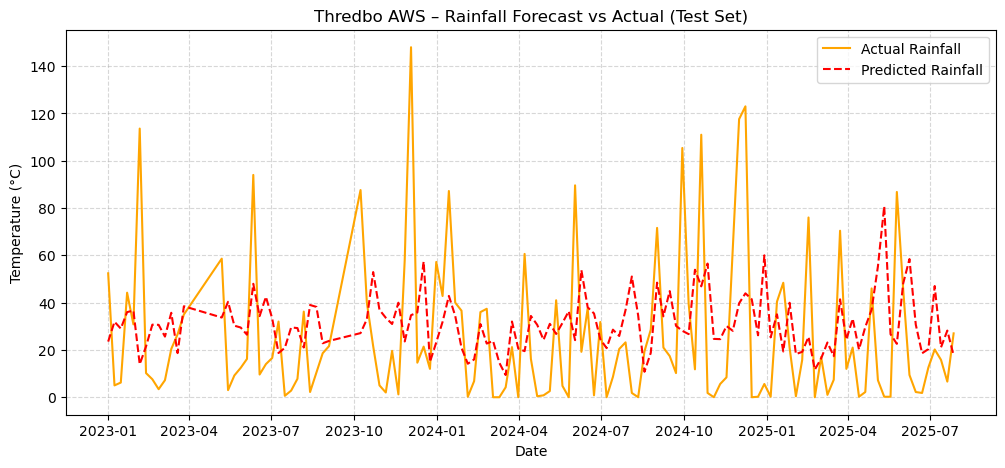

In [57]:
# =====================================================
# Plot TempMax and TempMin predictions vs actual
# =====================================================
for resort in pred_df["Resort"].unique():
    subset_actual = test[test["Resort"] == resort].set_index("Date")
    subset_pred   = pred_df[pred_df["Resort"] == resort].set_index("Date")
    
    # TempMax
    plt.figure(figsize=(12,5))
    plt.plot(subset_actual.index, subset_actual["TempMax"], label="Actual TempMax", color="blue")
    plt.plot(subset_pred.index, subset_pred["TempMax_pred"], label="Predicted TempMax", color="orange", linestyle="--")
    plt.title(f"{resort} – TempMax Forecast vs Actual (Test Set)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    
    # TempMin
    plt.figure(figsize=(12,5))
    plt.plot(subset_actual.index, subset_actual["TempMin"], label="Actual TempMin", color="green")
    plt.plot(subset_pred.index, subset_pred["TempMin_pred"], label="Predicted TempMin", color="red", linestyle="--")
    plt.title(f"{resort} – TempMin Forecast vs Actual (Test Set)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    
    # Rainfall
    plt.figure(figsize=(12,5))
    plt.plot(subset_actual.index, subset_actual["Rainfall"], label="Actual Rainfall", color="orange")
    plt.plot(subset_pred.index, subset_pred["Rainfall_pred"], label="Predicted Rainfall", color="red", linestyle="--")
    plt.title(f"{resort} – Rainfall Forecast vs Actual (Test Set)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


## Hyper Paramtunning

In [ ]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    rf, param_distributions=param_grid,
    n_iter=30, cv=3, scoring="r2", random_state=42, n_jobs=-1
)

search.fit(X_train, y_train["TempMax"])  # Example: tune for TempMax
print("Best Params:", search.best_params_)
print("Best CV R²:", search.best_score_)

Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Best CV R²: 0.8663061993569295


In [59]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    rf, param_distributions=param_grid,
    n_iter=30, cv=3, scoring="r2", random_state=42, n_jobs=-1
)

search.fit(X_train, y_train["TempMin"])  # Example: tune for TempMax
print("Best Params:", search.best_params_)
print("Best CV R²:", search.best_score_)

Best Params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best CV R²: 0.7601590795700212


We tested hyperparameter tuning via RandomizedSearchCV. For TempMax, tuning confirmed the model was near-optimal (R² ≈ 0.80). For TempMin, tuning actually reduced accuracy, suggesting the default Random Forest captured non-linearities better.

In [62]:
# Build dataframe with actual Date & Resort
pred_df = test[["Date","Resort"]].copy()

pred_df[["TempMax_pred","TempMin_pred","Rainfall_pred"]] = y_pred[:, :3]
pred_df.to_csv("rf_mulvar_predictions.csv", index=False)

print("Saved RF TempMax & TempMin predictions to rf_tempmax_tempmin_predictions.csv")
print(pred_df.head())

Saved RF TempMax & TempMin predictions to rf_tempmax_tempmin_predictions.csv
          Date                Resort  TempMax_pred  TempMin_pred  \
469 2023-01-01  Cabramurra SMHEA AWS     16.030032      7.015986   
470 2023-01-08  Cabramurra SMHEA AWS     18.699057      9.588180   
471 2023-01-15  Cabramurra SMHEA AWS     19.967580     10.257705   
472 2023-01-22  Cabramurra SMHEA AWS     19.084435      9.664237   
473 2023-01-29  Cabramurra SMHEA AWS     19.948560     10.452085   

     Rainfall_pred  
469        32.9340  
470        18.6584  
471        40.2676  
472        28.2304  
473        35.3316  


## Result 

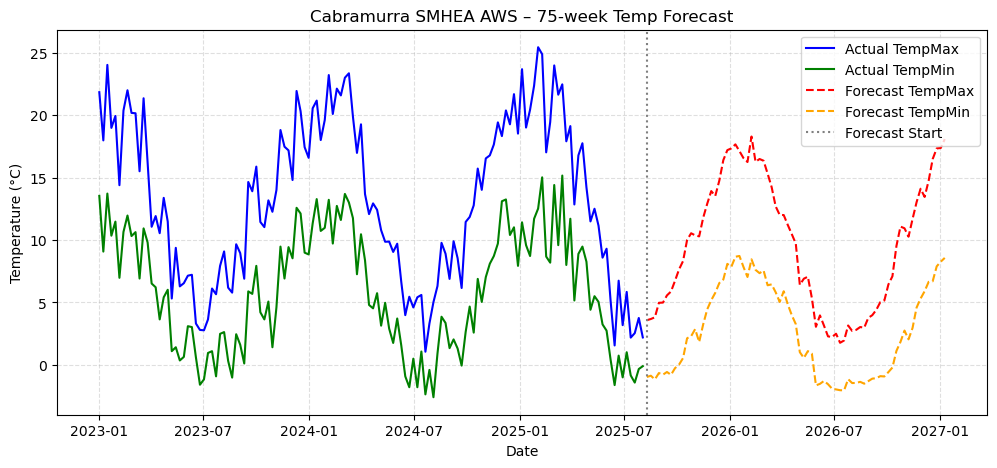

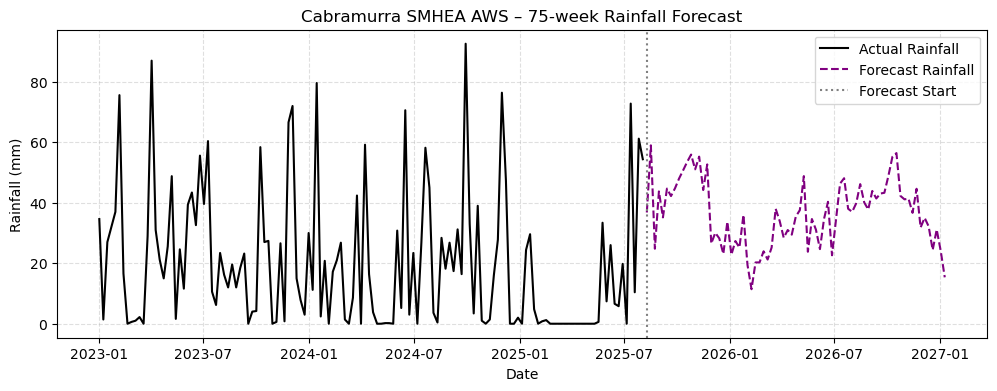

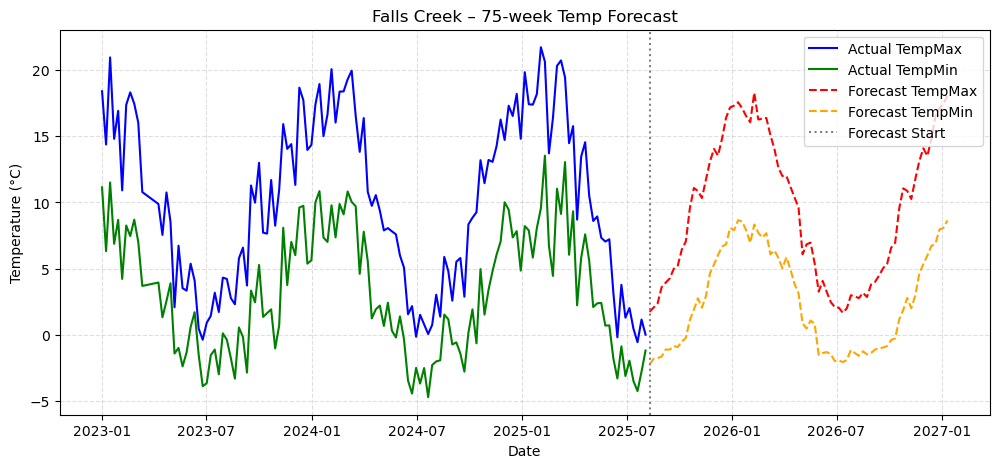

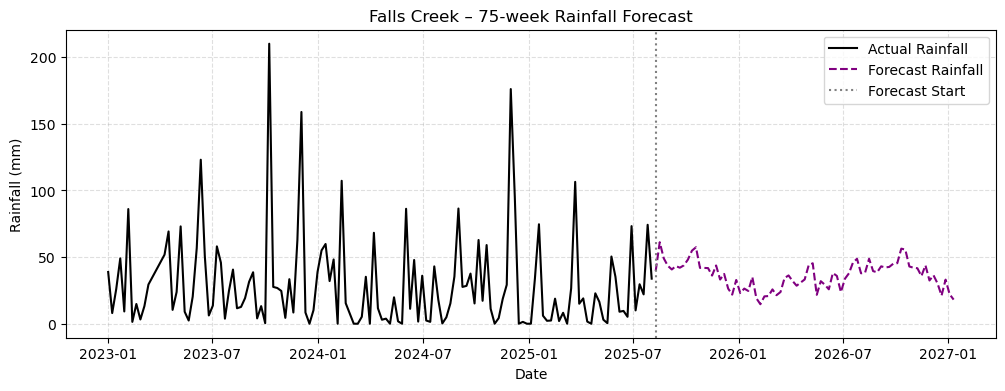

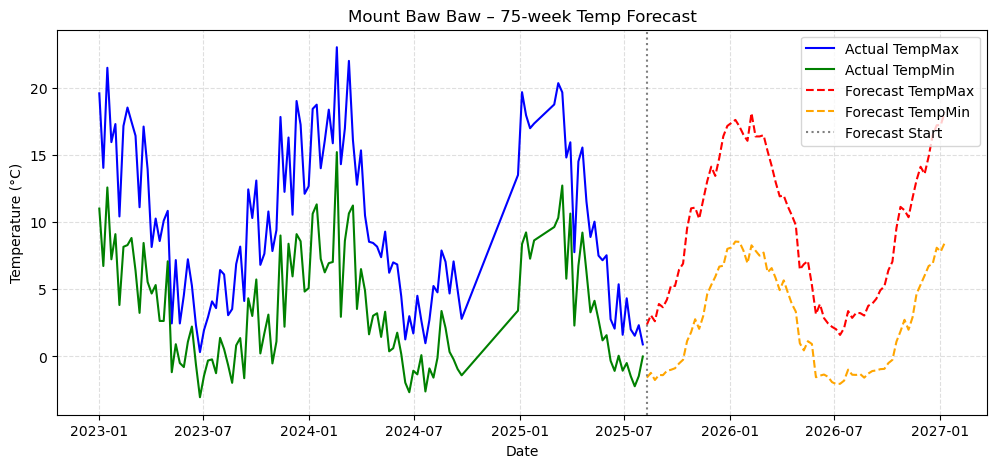

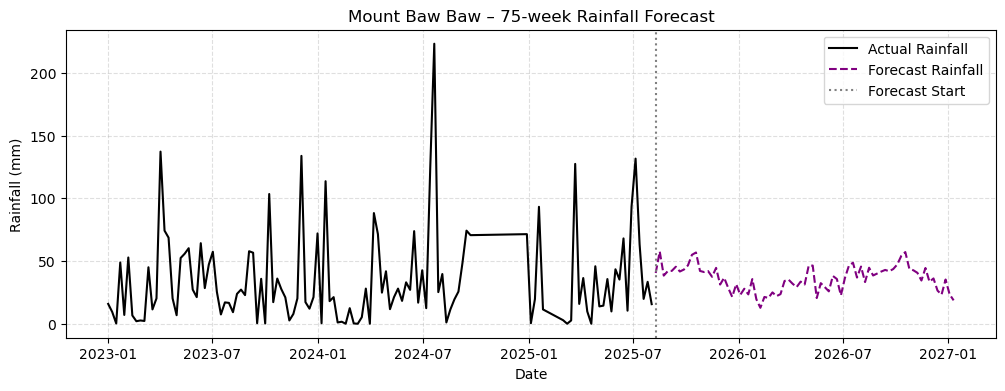

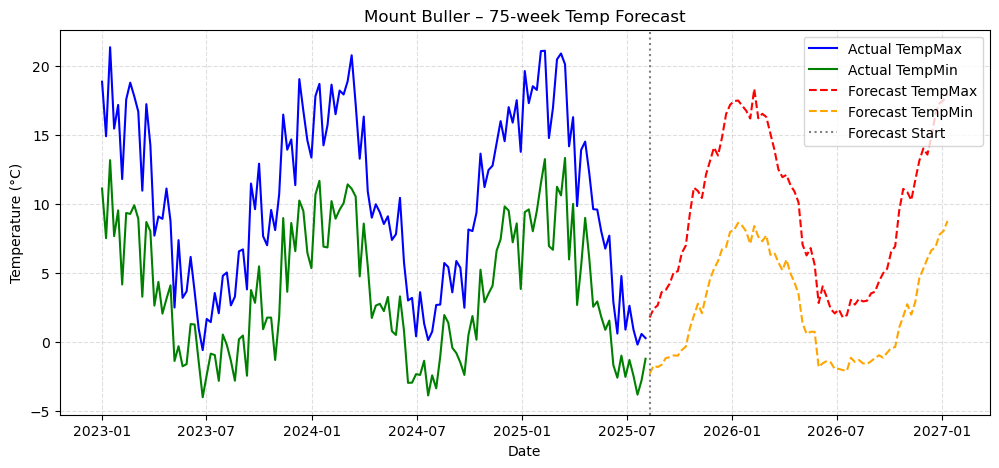

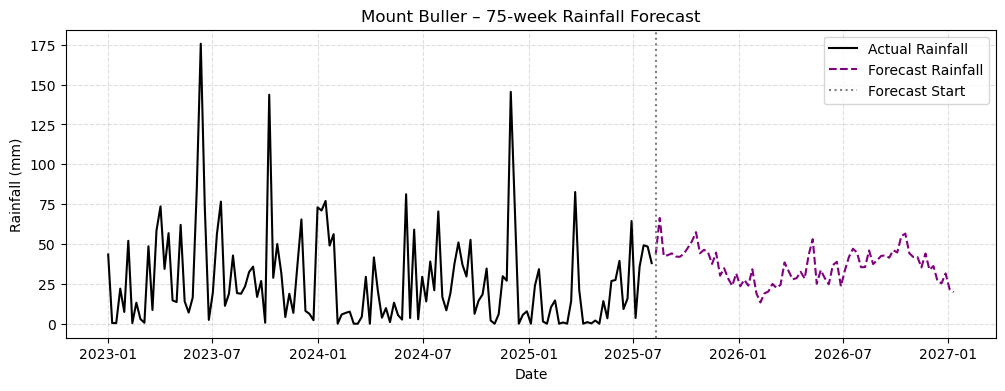

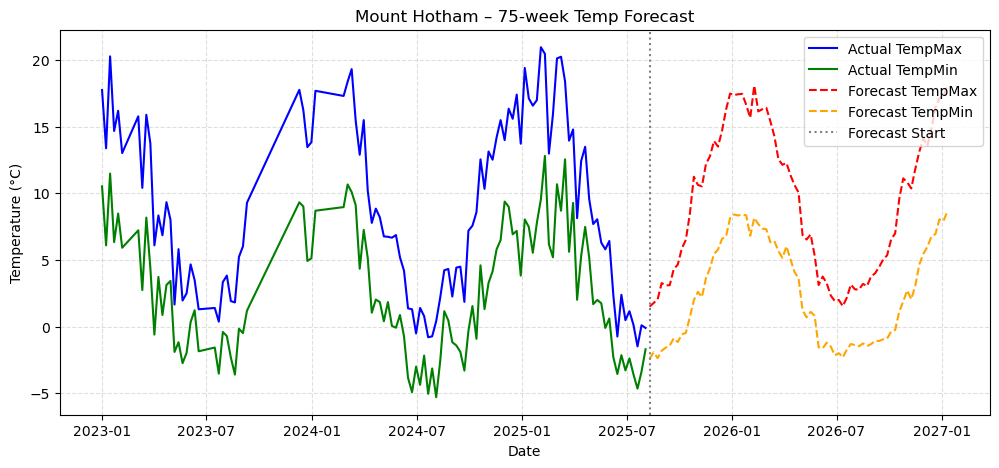

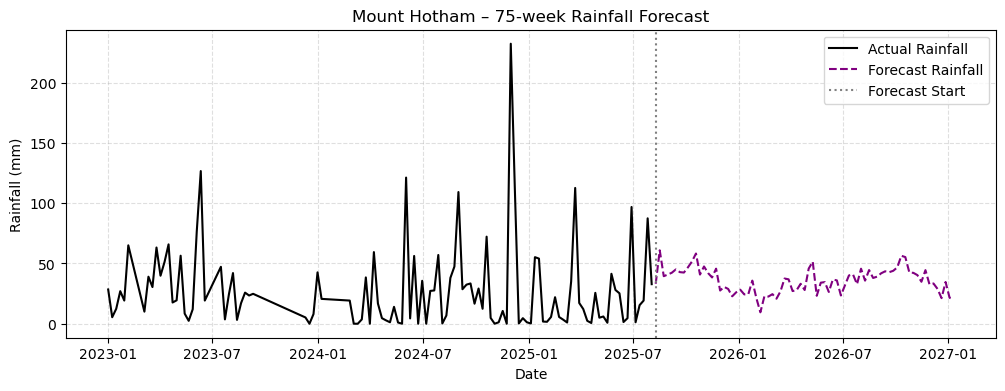

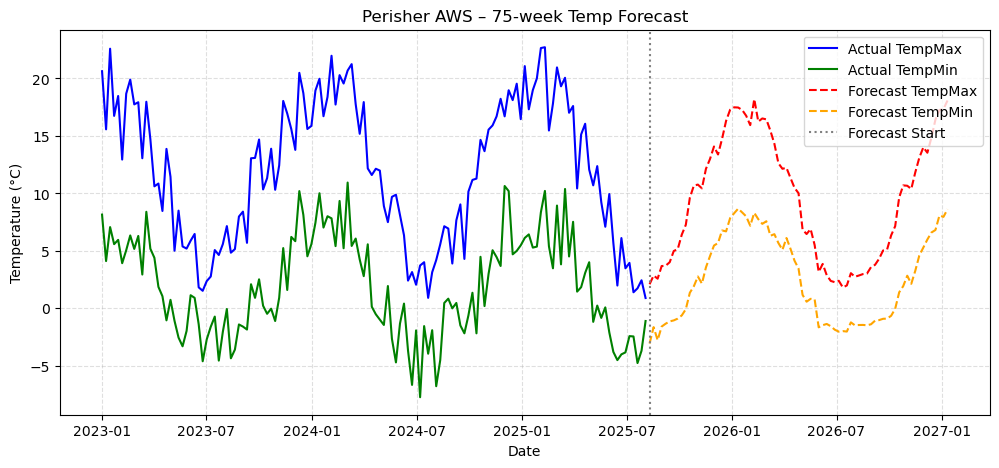

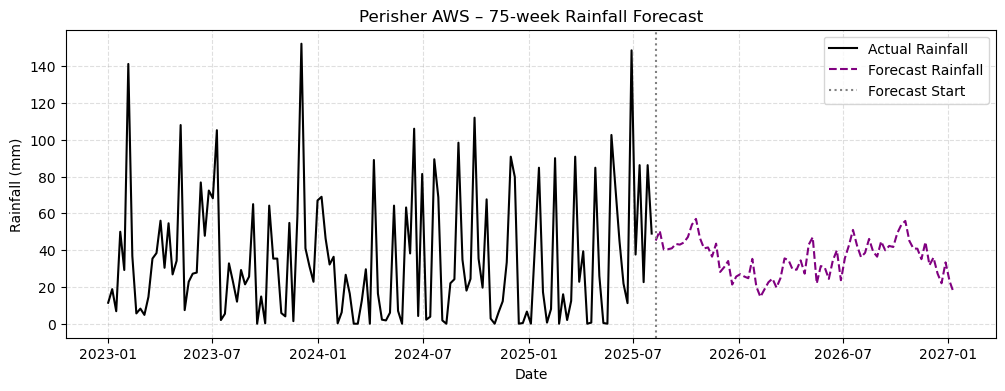

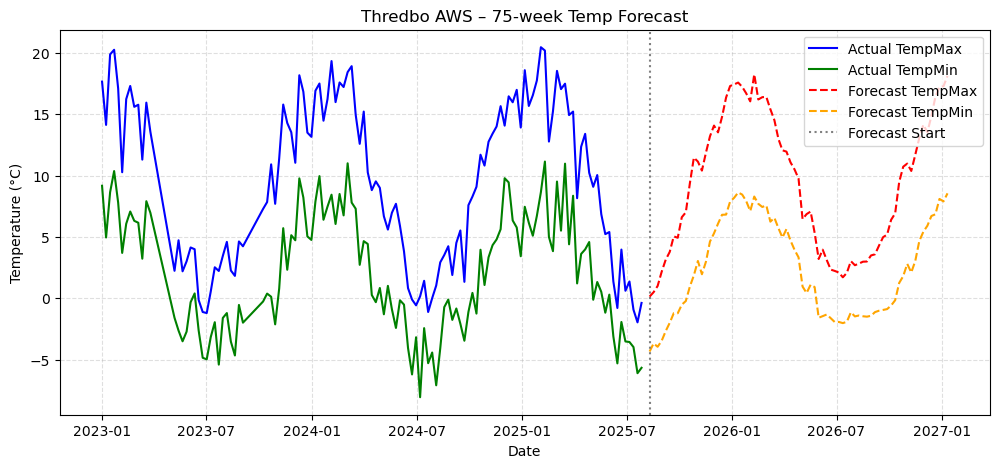

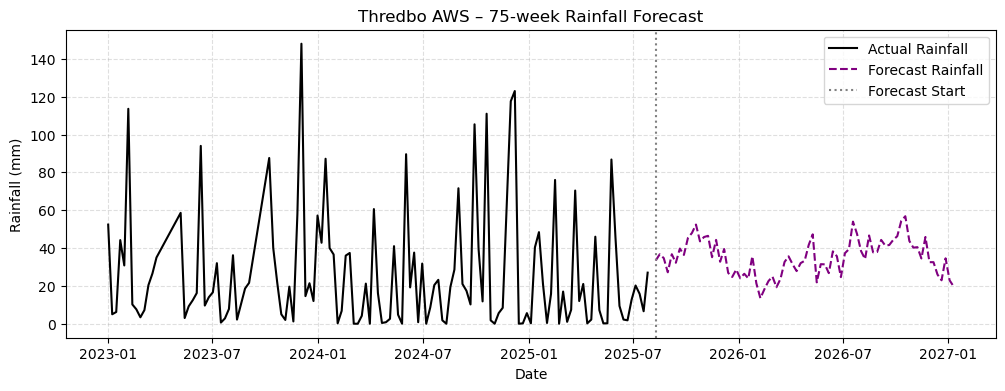

In [71]:
# =====================================================
# Recursive forecast 75 weeks ahead using trained model (best_rf)
# =====================================================
future_forecasts = {}
all_forecasts = []

last_date = df_weekly["Date"].max()
forecast_start = last_date + pd.Timedelta(weeks=1)
future_dates = pd.date_range(start=forecast_start, periods=75, freq="W-SUN")

for resort in df_weekly["Resort"].unique():
    history = df_weekly[df_weekly["Resort"] == resort].copy()
    test_history = history[history["Date"] >= "2023-01-01"]

    preds_tempmax, preds_tempmin, preds_rainfall = [], [], []

    # Initialize lags from last known actuals
    last_tempmax1, last_tempmax2 = history.iloc[-1]["TempMax"], history.iloc[-2]["TempMax"]
    last_tempmin1, last_tempmin2 = history.iloc[-1]["TempMin"], history.iloc[-2]["TempMin"]
    last_rain1,    last_rain2    = history.iloc[-1]["Rainfall"], history.iloc[-2]["Rainfall"]

    for d in future_dates:
        week = int(d.isocalendar().week)
        sin_week = np.sin(2 * np.pi * week / 52)
        cos_week = np.cos(2 * np.pi * week / 52)

        row = pd.DataFrame([{
            "TempMax_lag1": last_tempmax1,
            "TempMax_lag2": last_tempmax2,
            "TempMin_lag1": last_tempmin1,
            "TempMin_lag2": last_tempmin2,
            "Rainfall_lag1": last_rain1,
            "Rainfall_lag2": last_rain2,
            "sin_week": sin_week,
            "cos_week": cos_week
        }])

        # ✅ use already-trained model
        yhat = best_rf.predict(row[features])[0]   # [TempMax, TempMin, Rainfall]
        preds_tempmax.append(yhat[0])
        preds_tempmin.append(yhat[1])
        preds_rainfall.append(yhat[2])

        # update lags
        last_tempmax2, last_tempmax1 = last_tempmax1, yhat[0]
        last_tempmin2, last_tempmin1 = last_tempmin1, yhat[1]
        last_rain2,    last_rain1    = last_rain1, yhat[2]

    # Forecast DataFrame
    fcast_df = pd.DataFrame({
        "Date": future_dates,
        "Resort": resort,
        "TempMax_forecast": preds_tempmax,
        "TempMin_forecast": preds_tempmin,
        "Rainfall_forecast": preds_rainfall
    })

    future_forecasts[resort] = fcast_df
    all_forecasts.append(fcast_df)

    # ---- Plot Temps ----
    plt.figure(figsize=(12,5))
    plt.plot(test_history["Date"], test_history["TempMax"], label="Actual TempMax", color="blue")
    plt.plot(test_history["Date"], test_history["TempMin"], label="Actual TempMin", color="green")
    plt.plot(fcast_df["Date"], fcast_df["TempMax_forecast"], label="Forecast TempMax", linestyle="--", color="red")
    plt.plot(fcast_df["Date"], fcast_df["TempMin_forecast"], label="Forecast TempMin", linestyle="--", color="orange")
    plt.axvline(forecast_start, color="gray", linestyle=":", label="Forecast Start")
    plt.title(f"{resort} – 75-week Temp Forecast")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

    # ---- Plot Rainfall separately ----
    plt.figure(figsize=(12,4))
    plt.plot(test_history["Date"], test_history["Rainfall"], label="Actual Rainfall", color="black")
    plt.plot(fcast_df["Date"], fcast_df["Rainfall_forecast"], label="Forecast Rainfall", linestyle="--", color="purple")
    plt.axvline(forecast_start, color="gray", linestyle=":", label="Forecast Start")
    plt.title(f"{resort} – 75-week Rainfall Forecast")
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()

In [73]:
# =====================================================
# Combine all forecasts into one CSV
# =====================================================
forecast_df = pd.concat(all_forecasts).reset_index(drop=True)
forecast_df.to_csv("rf_forecasts_mulvar.csv", index=False)

print("Saved 75-week forecasts (TempMax, TempMin, Rainfall) → rf_forecasts_75weeks.csv")
print(forecast_df.head())

Saved 75-week forecasts (TempMax, TempMin, Rainfall) → rf_forecasts_75weeks.csv
        Date                Resort  TempMax_forecast  TempMin_forecast  \
0 2025-08-10  Cabramurra SMHEA AWS          3.578702         -0.966110   
1 2025-08-17  Cabramurra SMHEA AWS          3.675585         -0.865386   
2 2025-08-24  Cabramurra SMHEA AWS          3.811079         -1.158629   
3 2025-08-31  Cabramurra SMHEA AWS          4.971911         -0.650614   
4 2025-09-07  Cabramurra SMHEA AWS          4.989097         -0.780276   

   Rainfall_forecast  
0            36.7872  
1            58.9960  
2            24.8020  
3            43.7540  
4            35.1664  
